# Distance Timings

Our publication uses `numba` based distances from the `aeon` packages in our clustering 
implementations and experiments. In this notebook we compare the performance of the
`aeon` distances to the `dtw` package, `tslearn` and `sktime` implementations of DTW. 

We use the follow versions for each package in the default output:

 - aeon-0.3.0
 - dtw-1.4.0
 - tslearn-0.5.3.2
 - sktime-0.20.0

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from aeon.distances import dtw_distance as aeon_dtw
from aeon.distances.tests._utils import create_test_distance_numpy
from dtw import dtw as dtw_python_dtw
from sktime.dists_kernels import DtwDist as sktime_dtw
from tslearn.metrics import dtw as tslearn_dtw

warnings.filterwarnings("ignore")  # Hide warnings

In [2]:
def timing_experiment(x, y, distance_callable, average=10, params=None):
    """Time a distance experiment."""
    if params is None:
        params = {}
    total_time = 0
    for i in range(0, average):
        start = time.time()
        distance_callable(x, y, **params)
        total_time += time.time() - start

    return total_time / average


# dummy run to compile numba etc
x = create_test_distance_numpy(1, 10, 10, random_state=0)[0]
timing_experiment(x, x, aeon_dtw, average=1)
timing_experiment(
    x[0], x[0], dtw_python_dtw, params={"dist": lambda x, y: (x - y) ** 2}, average=1
)
timing_experiment(x, x, tslearn_dtw, average=1)
timing_experiment(x, x, sktime_dtw(), average=1)
x

array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 , -0.05160943,  0.20529925],
       [ 0.07202179,  0.72713675,  0.38051886,  0.06083751,  0.22193162,
         0.16683716,  0.74703954, -0.10257913,  0.15653385, -0.42704787],
       [-1.27649491,  0.3268093 ,  0.4322181 , -0.37108251,  1.13487731,
        -0.72718284,  0.02287926, -0.09359193,  0.76638961,  0.73467938],
       [ 0.07747371,  0.18908126, -0.44389287, -0.99039823, -0.17395607,
         0.07817448,  0.61514534,  0.60118992, -0.19366341, -0.15115138],
       [-0.52427648, -0.71000897, -0.8531351 ,  0.9753877 , -0.25482609,
        -0.21903715, -0.62639768,  0.38874518, -0.80694892, -0.10637014],
       [-0.44773328,  0.19345125, -0.25540257, -0.59031609, -0.01409111,
         0.21416594,  0.03325861,  0.15123595, -0.31716105, -0.18137058],
       [-0.33623022, -0.17977658, -0.40657314, -0.8631413 ,  0.08871307,
        -0.20089047, -0.81509917,  0.23139113

## Univariate Distance Timings

In this experiment we compare performance on a univariate series, raising the
series length by 50 each step and averaging over 10 runs.

In [3]:
aeon_timing = []
dtw_python_timing = []
tslearn_timing = []
sktime_timing = []
lengths = []

for i in range(50, 550, 50):
    lengths.append(i)
    distance_m_d = create_test_distance_numpy(2, 1, i, random_state=0)
    x = distance_m_d[0][0]
    y = distance_m_d[1][0]

    aeon_timing.append(timing_experiment(x, y, aeon_dtw))
    dtw_python_timing.append(
        timing_experiment(
            x, y, dtw_python_dtw, params={"dist": lambda x, y: (x - y) ** 2}
        )
    )
    tslearn_timing.append(timing_experiment(x, y, tslearn_dtw))
    sktime_timing.append(
        timing_experiment(x.reshape((1, 1, i)), y.reshape((1, 1, i)), sktime_dtw())
    )

In [4]:
print(aeon_timing)
print(tslearn_timing)
print(dtw_python_timing)
print(sktime_timing)

[0.0015954971313476562, 0.0, 0.00019965171813964843, 0.0001994609832763672, 0.00019311904907226562, 0.0003989219665527344, 0.0005983829498291016, 0.0007977962493896484, 0.0009973526000976562, 0.00139617919921875]
[0.0, 0.0, 0.0, 0.0001995563507080078, 0.00019979476928710938, 0.0005982398986816406, 0.001196908950805664, 0.0009979248046875, 0.0014006137847900391, 0.001595783233642578]
[0.004192161560058594, 0.01595149040222168, 0.03331141471862793, 0.05925397872924805, 0.09237089157104492, 0.1434168338775635, 0.18961143493652344, 0.24489173889160157, 0.37693352699279786, 0.38398103713989257]
[0.03690385818481445, 0.03172025680541992, 0.03410296440124512, 0.0402984619140625, 0.043180322647094725, 0.051262712478637694, 0.05744051933288574, 0.10990238189697266, 0.14532618522644042, 0.11210570335388184]


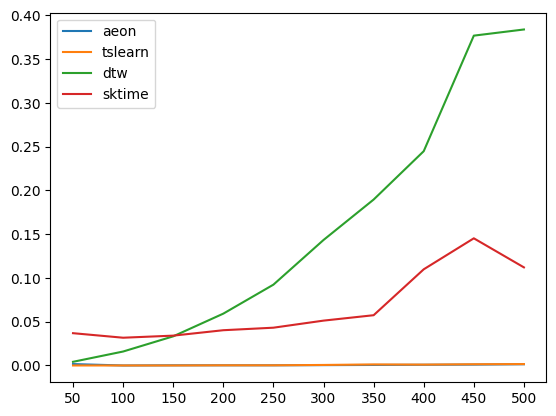

In [5]:
plt.plot(aeon_timing, label="aeon")
plt.plot(tslearn_timing, label="tslearn")
plt.plot(dtw_python_timing, label="dtw")
plt.plot(sktime_timing, label="sktime")
plt.legend()
plt.xticks(list(range(len(lengths))), lengths)
plt.show()

## Multivariate Distance Timings

In this experiment we compare performance on a multivariate series, raising both the
series length and number of channels by 50 each step and averaging over 10 runs.

The `dtw` package does not support multivariate series, so we exclude it.

In [6]:
aeon_timing = []
tslearn_timing = []
sktime_timing = []
lengths = []

for i in range(50, 550, 50):
    lengths.append(i)
    distance_m_d = create_test_distance_numpy(2, i, i, random_state=0)
    x = distance_m_d[0]
    y = distance_m_d[1]

    aeon_timing.append(timing_experiment(x, y, aeon_dtw))
    # tslearn expects the shape tp be (m, d) instead of (d, m)
    tslearn_timing.append(timing_experiment(x.transpose(), y.transpose(), tslearn_dtw))
    sktime_timing.append(
        timing_experiment(x.reshape((1, i, i)), y.reshape((1, i, i)), sktime_dtw())
    )

In [7]:
print(aeon_timing)
print(tslearn_timing)
print(sktime_timing)

[0.0001918315887451172, 0.000798177719116211, 0.00299220085144043, 0.007026290893554688, 0.014661788940429688, 0.0276275634765625, 0.04847054481506348, 0.0844810962677002, 0.09893527030944824, 0.16029653549194336]
[0.08747973442077636, 0.0005991458892822266, 0.0024773597717285155, 0.00638275146484375, 0.012765932083129882, 0.02264060974121094, 0.05485291481018066, 0.0596405029296875, 0.07699403762817383, 0.12229204177856445]
[0.00932307243347168, 0.010172033309936523, 0.013563966751098633, 0.02044649124145508, 0.03320589065551758, 0.05465383529663086, 0.08779778480529785, 0.21661005020141602, 0.27059736251831057, 0.333675479888916]


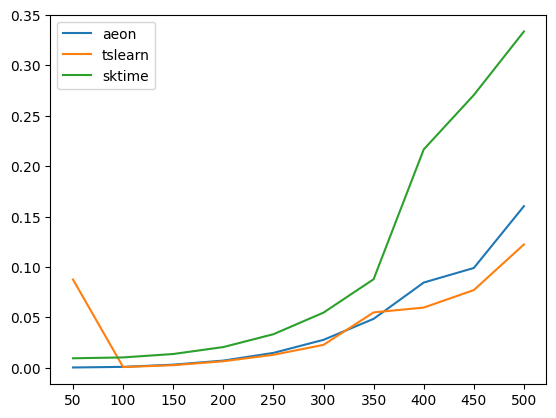

In [8]:
plt.plot(aeon_timing, label="aeon")
plt.plot(tslearn_timing, label="tslearn")
plt.plot(sktime_timing, label="sktime")
plt.legend()
plt.xticks(list(range(len(lengths))), lengths)
plt.show()

## Larger multivariate experiment

We keep the series compared above small to keep the notebook runtime low. In the
 following pre-computed experiment we compare the performance for larger series
length and dimensionality averaged over 30 runs per step.

In [9]:
# start 1000, end 10000, step 500, 30 average runs
csv = pd.read_csv("results/distance_notebook_timings.csv", index_col=0)
print(csv)

             1000      1500      2000      2500      3000      3500      4000  \
aeon     0.005453  0.012845  0.022739  0.037193  0.051308  0.071451  0.092952   
tslearn  0.012304  0.015375  0.028867  0.047718  0.063504  0.086363  0.110766   
sktime   0.138374  0.182864  0.222571  0.289339  0.363408  0.457018  0.537899   

             4500      5000      5500      6000      6500      7000      7500  \
aeon     0.116585  0.142927  0.178241  0.207480  0.243924  0.287327  0.324288   
tslearn  0.148099  0.170989  0.210569  0.249226  0.293594  0.336350  0.396900   
sktime   0.639533  0.794833  0.921391  1.073838  1.230945  1.400597  1.703857   

             8000      8500      9000      9500     10000  
aeon     0.437878  0.404185  0.452040  0.501346  0.561733  
tslearn  0.503390  0.466680  0.522787  0.585782  0.649676  
sktime   1.772326  1.913860  2.126502  2.408306  2.594621  


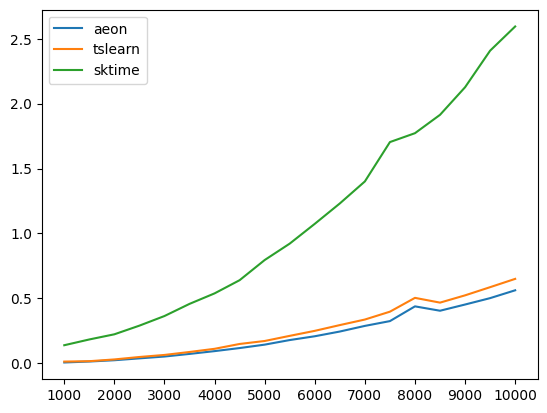

In [10]:
plt.plot(csv.iloc[0], label="aeon")
plt.plot(csv.iloc[1], label="tslearn")
plt.plot(csv.iloc[2], label="sktime")
plt.legend()
lengths = list(csv.columns.values)
plt.xticks(list(range(0, len(lengths), 2)), lengths[::2])
plt.show()